# 1. Постановка задачи

**Цель работы**: Вам нужно выявить определяющие успешность игры закономерности по статистическим данным до 2016 года из открытых иточников

Результат быдет использован магазином "Стримчик", который продаёт по всему миру компьютерные игры.

**Описание проекта:**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


# 2. Импорт датасета и библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math as mt
from plotly.subplots import make_subplots

In [2]:
def read_df(pth1:str, pth2:str) -> pd.DataFrame:
    try:
        df = pd.read_csv(pth1)
    except OSError as e:
        df = pd.read_csv(pth2)     
    return df

In [3]:
pth1 = '/datasets/games.csv'
pth2 = 'https://code.s3.yandex.net/datasets/games.csv' 
df = read_df(pth1, pth2)

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В датасете есть пропуски,ошибки в типах данных, столбцы и тектовые переменные не соответствуют snake_case

In [6]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

# 3. Предобработка данных

## 3.1. Snake_case

### 3.1.1 Наименования столбцов

Приведем столбцы к snake_case

In [7]:
df.columns = df.columns.str.lower()  

In [8]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Уже лучше, теперь к значениям

### 3.1.2 Значения в столбцах genre, platform

**Столбцы genre, platform**

In [9]:
df.genre = df.genre.str.lower()
df.platform = df.platform.str.lower()

In [10]:
df.genre.unique()

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy', nan], dtype=object)

In [11]:
df.platform.unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

**Столбец name**

In [12]:
df.name = df.name.str.lower()
df.name = df.name.str.replace(' ', '_')

In [13]:
df.name.unique()

array(['wii_sports', 'super_mario_bros.', 'mario_kart_wii', ...,
       'woody_woodpecker_in_crazy_castle_5', 'lma_manager_2007',
       'haitaka_no_psychedelica'], dtype=object)

## 3.2. Пропуски

В столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating_Score

### 3.2.1. Пропуски в столбцах name, genre

Скорее всего 2 пропуска в столбце Name связаны с тем, что эти игры вышли давно, плохо продались и их никто не помнит. Или они были ошибочно добавлены в ходе конвертации. Так же скорее всего 2 строки с пропусками в name имеют пропуски в genre

In [14]:
df[df['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Так оно и есть. Удалим данные строчки

In [15]:
df = df[df['name'].isna() != True]
df.reset_index(drop = True)
df.name.isna().sum()

0

In [16]:
df['genre'].isna().sum()

0

### 3.2.2. Пропуски в столбце year_of_release

In [17]:
df[df['year_of_release'].isna() == True ]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden_nfl_2004,ps2,NaN,sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,fifa_soccer_2004,ps2,NaN,sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,lego_batman:_the_videogame,wii,NaN,action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe_smackdown_vs._raw_2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space_invaders,2600,NaN,shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,pdc_world_championship_darts_2008,psp,NaN,sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,freaky_flyers,gc,NaN,racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,inversion,pc,NaN,shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,hakuouki:_shinsengumi_kitan,ps3,NaN,adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Если игра в своем имени содержит год выпуска, год выпуска очевиден

In [18]:
def year_from_name(df:pd.DataFrame) -> pd.DataFrame:    
    for i, row in df.iterrows():       
        if np.isnan(row['year_of_release']):            
            game_year = 0 
            game_name = row['name']
            splited = game_name.split('_')
            for element in splited:
                if element.isnumeric() == True and len(element) == 4:                  
                    df.loc[i,'year_of_release'] = element
    return df

In [19]:
df = year_from_name(df)

In [20]:
df.year_of_release.isna().sum()

254

In [21]:
df.platform.unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

Это 1.5 % от всех записей. Отбросим данные значения

In [22]:
df = df[df['year_of_release'].isna() != True ]
df= df.reset_index(drop = True)

In [23]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8465
user_score         6609
rating             6681
dtype: int64

### 3.2.3. Пропуски в столбце user_score

Значения tbd в столбце user_score скорее всего расшифровывается как to be done (к заполнению).
Эти значения надо из этого столбца убрать, так как это мешает дальнейшему анализу 
К сожалению рейтинг пользователей в рамках данного датасета посчитать невозможно, поэтому будем заполнять данные значения NAN.
На всякий случай сохраним tbd в отдельном столбце is_tbd

In [24]:
df[df['user_score'] == 'tbd'].user_score.count()

2378

In [25]:
def tbd(user_score: str) -> bool:
    if user_score == 'tbd':        
        return True
    else:
        return False

In [26]:
df['is_tbd'] = df.user_score.map(tbd)

In [27]:
df.user_score.replace(r'tbd', np.nan, regex=True, inplace = True)
df.reset_index(drop= True)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd
0,wii_sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E,False
1,super_mario_bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,False
2,mario_kart_wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,False
3,wii_sports_resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E,False
4,pokemon_red/pokemon_blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
16454,samurai_warriors:_sanada_maru,ps3,2016.0,action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,False
16455,lma_manager_2007,x360,2006.0,sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,False
16456,haitaka_no_psychedelica,psv,2016.0,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,False
16457,spirits_&_spells,gba,2003.0,platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,False


In [28]:
df[df['user_score'] == 'tbd'].user_score.count()

0

In [29]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8465
user_score         8987
rating             6681
is_tbd                0
dtype: int64

### 3.2.4. Пропуски в столбце rating

In [30]:
def checkNaN(str):
      return str != str

In [31]:
def rating_by_genre(df: pd.DataFrame) -> pd.DataFrame:
    rating_game = {}
    for genre_game in df.genre.unique():    
        rating_game[genre_game] = df[df['genre'] == genre_game].rating.mode().values[0]   

    for i, row in df.iterrows():
        if checkNaN(row['rating']):           
             df.loc[i,'rating'] = rating_game.get(df.loc[i,'genre'])   

    pass

## 3.3. Типы данных

Приведем столбцы **user_score** и **year_of_release**  к нужным типам данных

Так как столбец **year_of_release** содержит только год, нет смысла переводить его в datetime
Переведем в int

In [34]:
df.year_of_release = df.year_of_release.astype('int32')
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8,E,False
1,super_mario_bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,False
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,False
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8,E,False
4,pokemon_red/pokemon_blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,False


Приведем столбец **user_score** к типу float

In [35]:
df.user_score = df.user_score.astype(float)

Остальные столбцы имеют нужные типы

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16459 entries, 0 to 16458
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16459 non-null  object 
 1   platform         16459 non-null  object 
 2   year_of_release  16459 non-null  int32  
 3   genre            16459 non-null  object 
 4   na_sales         16459 non-null  float64
 5   eu_sales         16459 non-null  float64
 6   jp_sales         16459 non-null  float64
 7   other_sales      16459 non-null  float64
 8   critic_score     7994 non-null   float64
 9   user_score       7472 non-null   float64
 10  rating           9778 non-null   object 
 11  is_tbd           16459 non-null  bool   
dtypes: bool(1), float64(6), int32(1), object(4)
memory usage: 1.3+ MB


## 3.4. Обработка дубликатов и выбросов

Посмотрим явные дубликаты

In [37]:
df.duplicated().sum()

0

**Столбец platform**

В столбце platform есть редко встречающиеся платформы. 
Смысла их оставлять нет

In [38]:
df['platform'].value_counts()

ps2     2134
ds      2122
ps3     1306
wii     1286
x360    1234
psp     1194
ps      1190
pc       957
gba      811
xb       806
gc       543
3ds      512
psv      429
ps4      392
n64      316
xone     247
snes     239
sat      173
wiiu     147
2600     116
nes       98
gb        97
dc        52
gen       27
ng        12
scd        6
ws         6
3do        3
tg16       2
gg         1
pcfx       1
Name: platform, dtype: int64

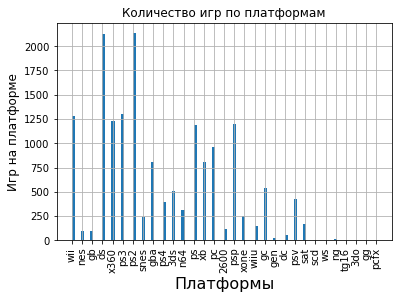

In [39]:
df['platform'].hist(bins = 100);
plt.title('Количество игр по платформам')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Игр на платформе', fontsize = 12); 
plt.xticks(rotation=90)
plt.show()

In [40]:
df['platform'].shape[0]

16459

In [41]:
df['platform'].describe()

count     16459
unique       31
top         ps2
freq       2134
Name: platform, dtype: object

Уберем все, что встречается меньше 13 раз

In [42]:
def remove_reare_platforms(df:pd.DataFrame) -> pd.DataFrame:
    for platform in df.platform.unique():
        if df[df['platform'] == platform].platform.count() < 13: 
            df = df[df['platform'] != platform]
    return df

In [43]:
df = remove_reare_platforms(df)

In [44]:
df['platform'].value_counts()

ps2     2134
ds      2122
ps3     1306
wii     1286
x360    1234
psp     1194
ps      1190
pc       957
gba      811
xb       806
gc       543
3ds      512
psv      429
ps4      392
n64      316
xone     247
snes     239
sat      173
wiiu     147
2600     116
nes       98
gb        97
dc        52
gen       27
Name: platform, dtype: int64

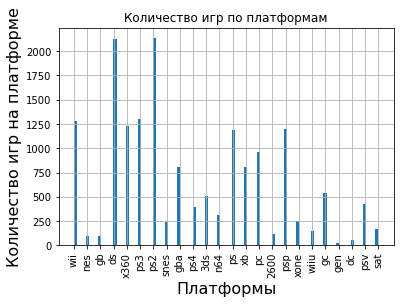

In [45]:
df['platform'].hist(bins = 100);
plt.title('Количество игр по платформам')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Количество игр на платформе', fontsize = 16); 
plt.xticks(rotation=90)
plt.show();

In [46]:
df['platform'].shape[0]

16428

**Столбцы user_score и сritic_score**

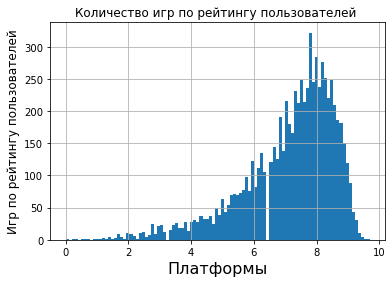

In [47]:
df['user_score'].hist(bins = 100);
plt.title('Количество игр по рейтингу пользователей ')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Игр по рейтингу пользователей', fontsize = 12); 
plt.show();

In [48]:
df['user_score'].describe()

count    7472.000000
mean        7.127610
std         1.499212
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

In [49]:
df['user_score'].count()

7472

In [50]:
df['user_score'].value_counts()

7.8    322
8.0    285
8.2    277
8.3    252
7.5    249
      ... 
1.5      2
0.3      2
1.1      2
0.0      1
9.7      1
Name: user_score, Length: 95, dtype: int64

уберем значения меньше 4 и больше 9.4

In [51]:
df[df['user_score'] < 4].user_score.count()

339

In [52]:
df[df['user_score'] > 9.4].user_score.count()

8

In [53]:
df['user_score'].shape[0]

16428

In [54]:
df = df[(df['user_score'].isna() == True) | ((df['user_score'] > 2) & (df['user_score'] < 9.4))]

In [55]:
df['user_score'].shape[0]

16351

In [56]:
df['critic_score'].shape[0]

16351

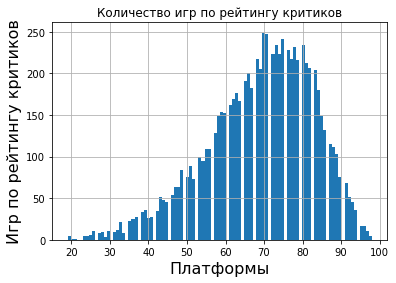

In [57]:
df['critic_score'].hist(bins = 100);
plt.title('Количество игр по рейтингу критиков')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Игр по рейтингу критиков', fontsize = 16); 
plt.show()

In [58]:
df['critic_score'].value_counts()

70.0    249
71.0    248
75.0    241
80.0    234
73.0    234
       ... 
24.0      4
23.0      4
29.0      3
21.0      1
20.0      1
Name: critic_score, Length: 79, dtype: int64

In [59]:
df['critic_score'].describe()

count    7942.000000
mean       69.098716
std        13.773779
min        19.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Уберем значения больше 96 

In [60]:
df = df[(df['critic_score'].isna() == True) | ((df['critic_score'] > 9) & (df['critic_score'] < 96))]

In [61]:
df['critic_score'].value_counts()

70.0    249
71.0    248
75.0    241
73.0    234
80.0    234
       ... 
23.0      4
24.0      4
29.0      3
21.0      1
20.0      1
Name: critic_score, Length: 76, dtype: int64

In [62]:
df['critic_score'].shape[0]

16319

В имени игр присутствуют годы выпуска. В рамках данного датасета   
нет возможности проверить действительно ли в наименование игры присутствует год (как например fifa2004) или жто ошибка

## 3.4.1 Обработка неполных дубликатов

Проверим игры с одинаковыми названиями, годом релиза, платформой но в с отличиями в других столбцах

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16319 entries, 0 to 16458
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16319 non-null  object 
 1   platform         16319 non-null  object 
 2   year_of_release  16319 non-null  int32  
 3   genre            16319 non-null  object 
 4   na_sales         16319 non-null  float64
 5   eu_sales         16319 non-null  float64
 6   jp_sales         16319 non-null  float64
 7   other_sales      16319 non-null  float64
 8   critic_score     7910 non-null   float64
 9   user_score       7363 non-null   float64
 10  rating           9669 non-null   object 
 11  is_tbd           16319 non-null  bool   
dtypes: bool(1), float64(6), int32(1), object(4)
memory usage: 1.4+ MB


In [64]:
df = df.reset_index(drop= True)

In [65]:
def check_half_duplicates(df:pd.DataFrame):  
    for i,row in df.iterrows():
        if (df[(df['name'] == row['name']) 
              & (df['platform'] == row['platform'])
              & (df['year_of_release'] == row['year_of_release'])].shape[0]) > 1:
            print(row['name'])
    return 

In [66]:
df[df[['name', 'platform', 'year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd
578,madden_nfl_13,ps3,2012,sports,2.11,0.22,0.0,0.23,83.0,5.5,E,False
15846,madden_nfl_13,ps3,2012,sports,0.00,0.01,0.0,0.00,83.0,5.5,E,False


In [68]:
df[df['name'] == 'madden_nfl_13']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd
483,madden_nfl_13,x360,2012,sports,2.53,0.15,0.0,0.17,81.0,5.8,E,False
578,madden_nfl_13,ps3,2012,sports,2.11,0.22,0.0,0.23,83.0,5.5,E,False
3894,madden_nfl_13,wii,2012,sports,0.47,0.00,0.0,0.03,NaN,7.3,E,False
5755,madden_nfl_13,psv,2012,sports,0.28,0.00,0.0,0.02,63.0,7.3,E,False
6907,madden_nfl_13,wiiu,2012,sports,0.21,0.00,0.0,0.02,75.0,6.7,E,False
15846,madden_nfl_13,ps3,2012,sports,0.00,0.01,0.0,0.00,83.0,5.5,E,False


Единственным неполным дубликатом является строка с индексом 15846. Скорее всего она появилась в результате ошибки
Уберем данную строку

In [69]:
df = df[df.index != 15846].reset_index(drop= True)

Проверим игры с одинаковыми названиями, жанром выпуска но в с отличиями в других столбцах

## 3.5. Подсчет суммарных продаж во всех регионах

Суммируем продажи в na, eu, jp и others в отдельный столбец

In [70]:
def total_sales(df:pd.DataFrame) -> pd.DataFrame:
    for i, row in df.iterrows():
        df.loc[i, 'total_sales'] = (df.loc[i, 'na_sales'] + 
                                    df.loc[i, 'eu_sales'] + 
                                    df.loc[i, 'jp_sales'] +
                                    df.loc[i, 'other_sales'])
    pass

In [72]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] +df['other_sales']

In [73]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd,total_sales
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,False,82.54
1,super_mario_bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,False,40.24
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,False,35.52
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,False,32.77
4,pokemon_red/pokemon_blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,False,31.38


**Вывод по предобработке данных:**

В ходе предобработки данных было выявлено следующее:  

1. Наименования столбцов и значений не соответствует snake_case
2. В столбцах name, genre, platform, year_of_release, critic_score, user_score, rating есть пропуски
3. Неправильные типы данных в столбцах year_of_release, user_score
4. Наличие значений 'tbd' в столбце user_score
5. Явные и не явные дубликаты отсуствуют
6. Присутствует один неполный дубликат (игра madden_nfl_13)

В ходе данного этапа:

1. Наименования столбцов были приведены к snake_case   
2. 2 строки со значениями NAN в столбцах name, genre были отброшены. 
3. Там где в имени игры присутствует год и пропущены значения year_of_release, значения в столбце year_of_release были заполнены из имени игры. Остальные значения отброшены
4. Значения 'tbd' в столбце user_score были заполнены NAN, так как tbd = to be done по смыслу и есть NAN. На всякий случай значения 'tbd' были вынесены в отдельный столбец is_tbd
5. Изменены типы в столбцах user_score и year_of_release
6. Обработаны выбросы
7. Добавлен столбец 'total_sales', с суммами продаж по всем регионам
8. Удален неполный дубликат

Данные ошибки могли появиться врезультате человеческого фактора, работы/конвертации стороннего ПО



# 4. Исследовательский анализ данных

## 4. 1. Количество игр по годам

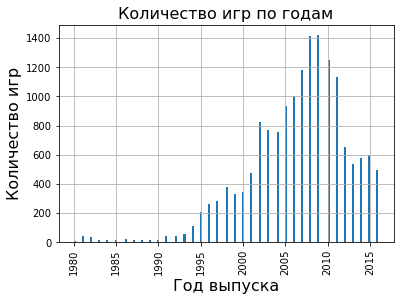

In [74]:
df.year_of_release.hist(bins = 150)
plt.xticks(rotation='vertical');
plt.title('Количество игр по годам', fontsize = 16);
plt.xlabel('Год выпуска', fontsize = 16);
plt.ylabel('Количество игр', fontsize = 16);

In [75]:
df.year_of_release.head()

0    2006
1    1985
2    2008
3    2009
4    1996
Name: year_of_release, dtype: int32

Посмотрим количество записей до 2000 года в процентном соотношении к общему количеству

In [76]:
df[df['year_of_release'] < 1995].shape[0]/df.shape[0] * 100

2.8925113371736733

Вывод: так как игры, выпущенные до 1995 года составляют ~ 3% от продаж, их можно не учитывать 

## 4. 2. Динамика продаж по платформам

Построим графики для изменения продаж за годы по платформам

In [77]:
plot1 = df.pivot_table(index=['year_of_release', 'platform'], values= 'total_sales', aggfunc= 'sum').reset_index(drop = False)

In [78]:
def plot_dynamics(plot1: pd.DataFrame):
    for platform in plot1.platform.unique():
        plot1[plot1['platform'] == platform].plot('year_of_release','total_sales', color='orange',linewidth=2, legend= False); 
        plt.title(f'Динамика продаж по платформе {platform}', fontsize = 16);
        plt.xlabel('Год выпуска', fontsize = 16);
        plt.ylabel('Суммарные продажи', fontsize = 16);  
                     
    return  plot1

C:\Users\usach\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


,year_of_release,platform,total_sales
0,1980,2600,11.38
1,1981,2600,35.68
2,1982,2600,28.88
3,1983,2600,5.84
4,1983,nes,10.96
...,...,...,...
219,2016,psv,4.25
220,2016,wii,0.18
221,2016,wiiu,4.60
222,2016,x360,0.96


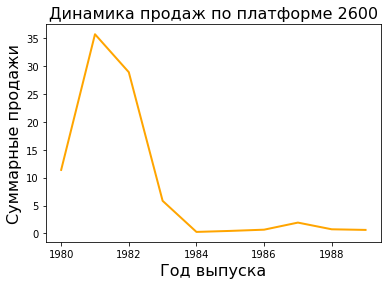

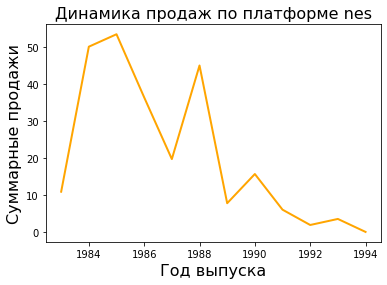

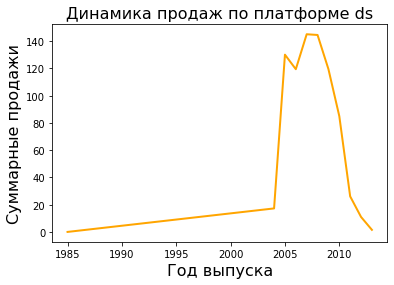

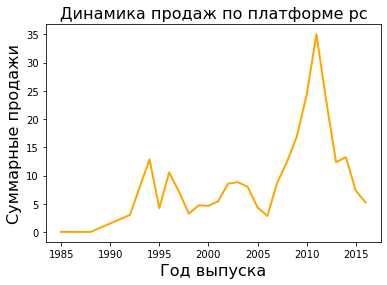

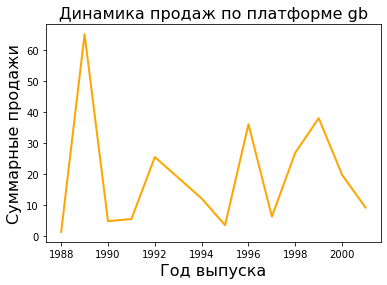

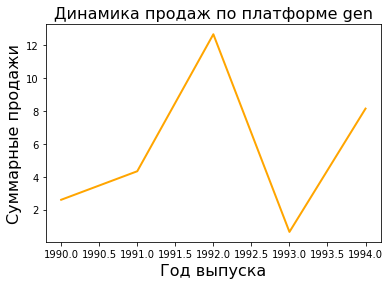

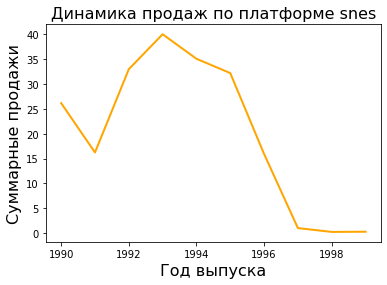

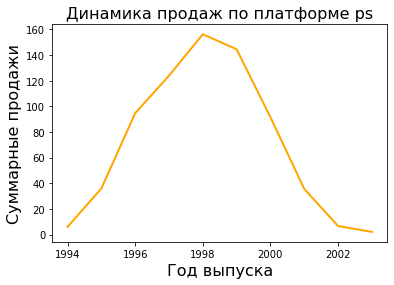

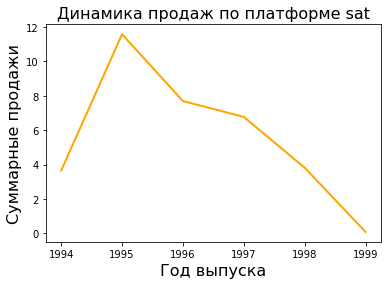

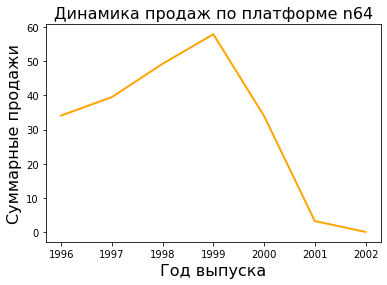

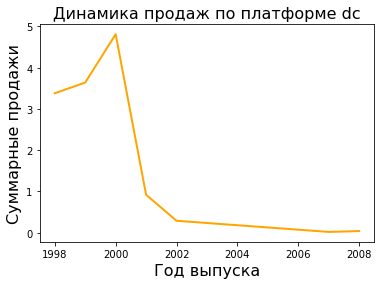

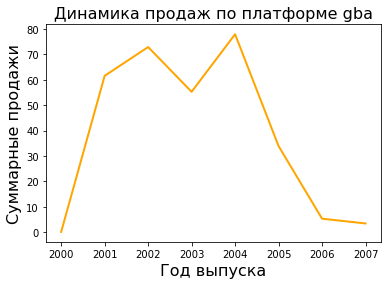

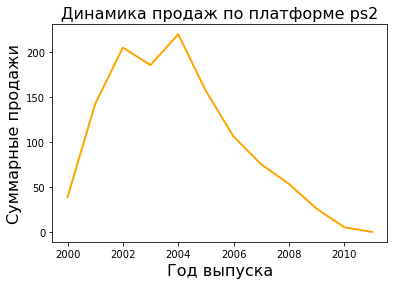

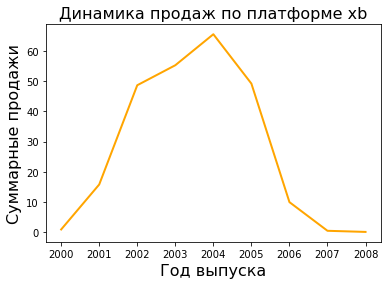

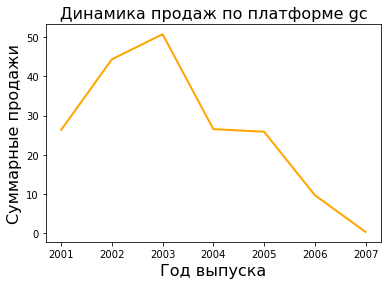

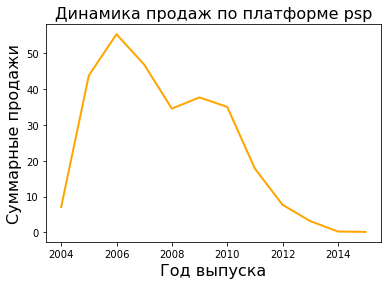

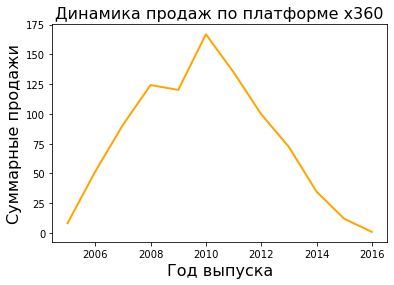

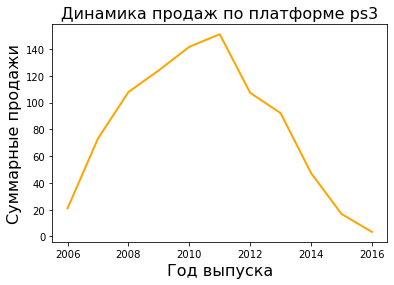

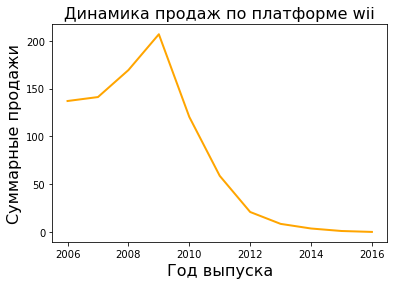

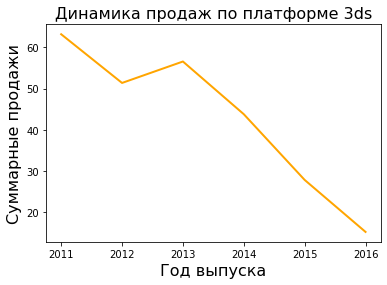

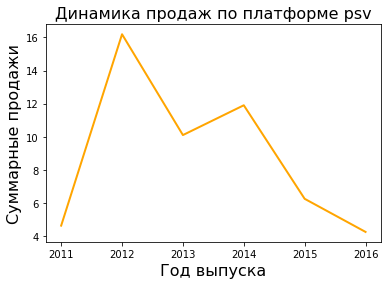

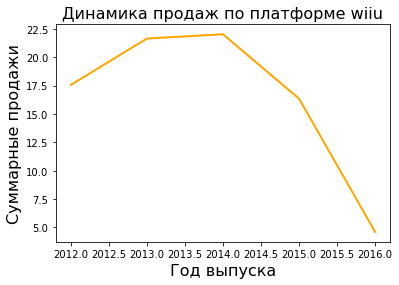

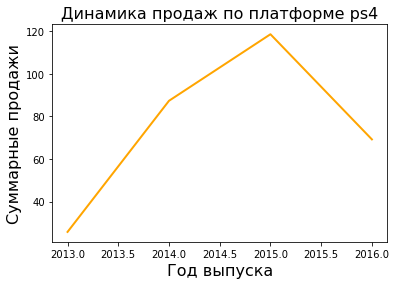

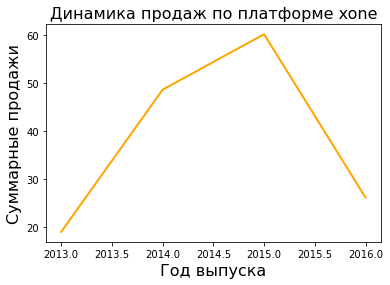

In [79]:
plot_dynamics(plot1)

In [80]:
plot1

,year_of_release,platform,total_sales
0,1980,2600,11.38
1,1981,2600,35.68
2,1982,2600,28.88
3,1983,2600,5.84
4,1983,nes,10.96
...,...,...,...
219,2016,psv,4.25
220,2016,wii,0.18
221,2016,wiiu,4.60
222,2016,x360,0.96


Вычислим и визуализируем 'время жизни' каждой платформы

In [81]:
plot1.platform.unique()

array(['2600', 'nes', 'ds', 'pc', 'gb', 'gen', 'snes', 'ps', 'sat', 'n64',
       'dc', 'gba', 'ps2', 'xb', 'gc', 'psp', 'x360', 'ps3', 'wii', '3ds',
       'psv', 'wiiu', 'ps4', 'xone'], dtype=object)

In [82]:
def calculate_life_cycle(df:pd.DataFrame) -> pd.DataFrame:   
    for platform in df.platform.unique():
        life_cycle = df[df['platform'] == platform].year_of_release.max() - df[df['platform'] == platform].year_of_release.min()
        for i, row in df.iterrows():
            if df.loc[i,'platform'] == platform:                    
                    df.loc[i,'life_cycle'] = life_cycle   
    return df

In [83]:
plot1 = calculate_life_cycle(plot1)

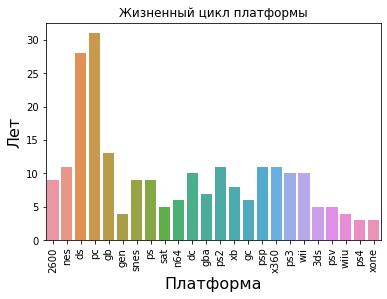

In [84]:
sns.barplot(data= plot1, x='platform', y='life_cycle');
plt.title('Жизненный цикл платформы')
plt.xlabel('Платформа', fontsize = 16);
plt.ylabel('Лет', fontsize = 16); 
plt.xticks(rotation=90)
plt.show()

Расчитаем медианное значение времени жизни платформы

In [85]:
plot1.life_cycle.median()

10.0

**Вывод**: 
характерный срок появляются новые и исчезают старые платформы - 8 лет

## 4. 3. Актуальный период

По предыдущим графикам видно, что количество игр до 2005 года ничтожно мало. Так же видно, что срок жизни платформы 8 лет. В дальнейшем будем оперировать данными об играх, вышедших после 2012 года так как они укладываются в 0.5 срока жизни платформы

In [86]:
df_actual = df[df['year_of_release'] > 2012]

Так же отбросим редкие платформы

In [87]:
df_actual.platform.value_counts()

ps4     387
psv     356
ps3     340
3ds     303
xone    245
pc      186
x360    182
wiiu    115
psp      67
wii      23
ds        8
Name: platform, dtype: int64

In [88]:
df_actual = remove_reare_platforms(df_actual)

## 4. 4. Лидирующие и падающие платформы 

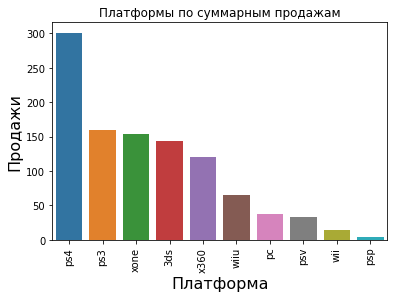

In [89]:
(sns.barplot(data= df_actual.pivot_table(index= 'platform', values= 'total_sales', aggfunc = 'sum')
             .reset_index(drop = False).sort_values(by = 'total_sales', ascending = False),              
             x= 'platform', y='total_sales'));
plt.title('Платформы по суммарным продажам')
plt.xlabel('Платформа', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 
plt.xticks(rotation=90)
plt.show()

Вывод: Самые прибыльные платформы - ps4,ps3,xone

In [90]:
plot2 = df_actual.pivot_table(index=['year_of_release', 'platform'], values= 'total_sales', aggfunc= 'sum').reset_index(drop = False)

In [91]:
plot2.platform.unique()

array(['3ds', 'pc', 'ps3', 'ps4', 'psp', 'psv', 'wii', 'wiiu', 'x360',
       'xone'], dtype=object)

,year_of_release,platform,total_sales
0,2013,3ds,56.57
1,2013,pc,12.38
2,2013,ps3,92.16
3,2013,ps4,25.77
4,2013,psp,3.14
5,2013,psv,10.10
6,2013,wii,8.59
7,2013,wiiu,21.65
8,2013,x360,72.25
9,2013,xone,18.96


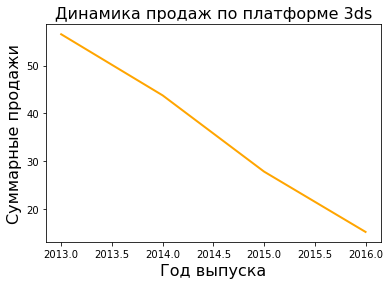

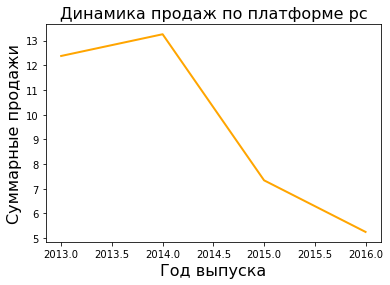

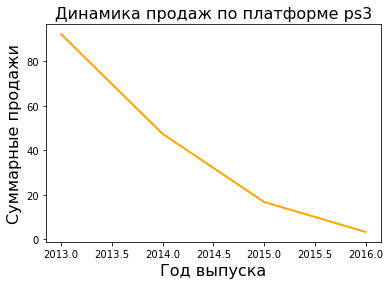

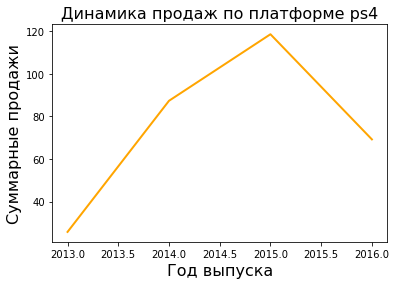

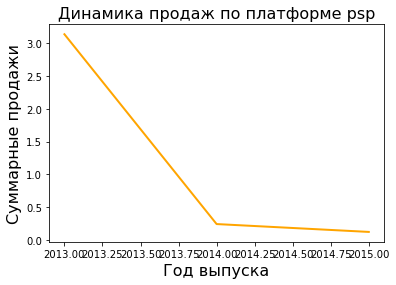

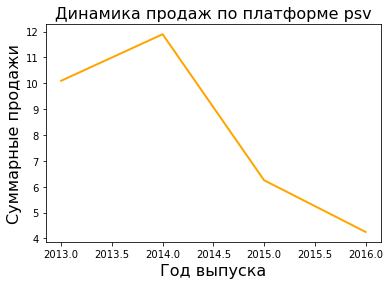

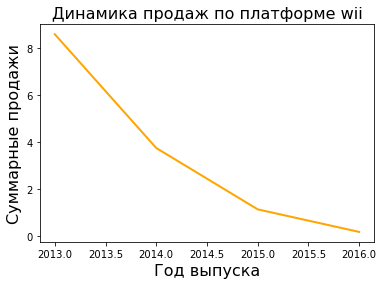

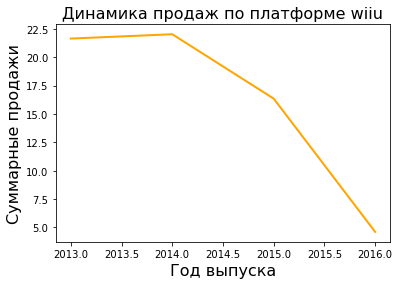

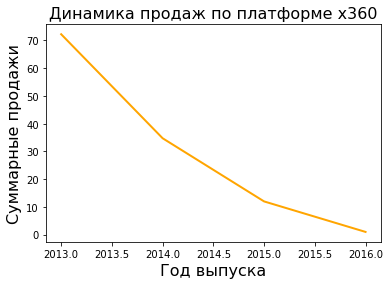

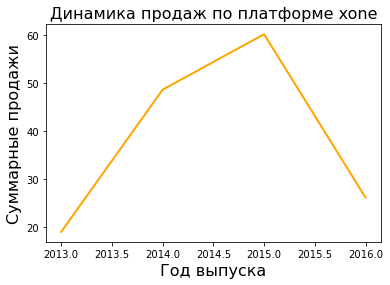

In [92]:
plot_dynamics(plot2)

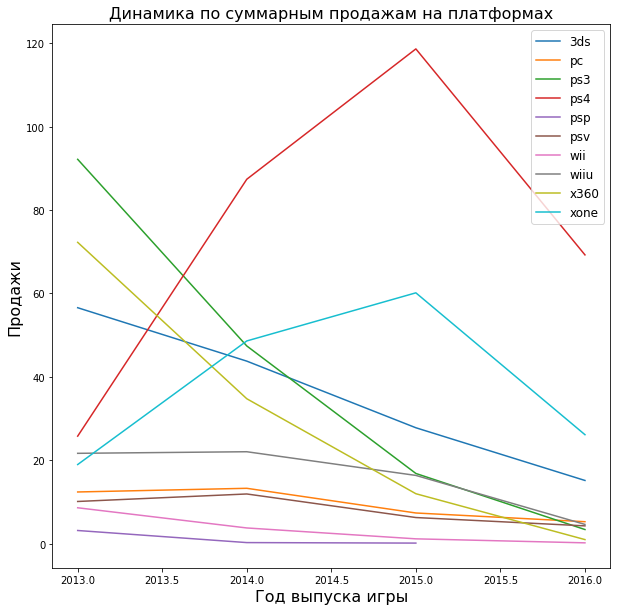

In [93]:
fig, ax = plt.subplots(figsize= [10,10])
sns.lineplot(ax= ax, x='year_of_release', y='total_sales', hue='platform',
             data= plot2);
plt.title('Динамика по суммарным продажам на платформах', fontsize = 16)
plt.xlabel('Год выпуска игры', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 
plt.legend(fontsize = 12);

Из графиков видно, что все платформы падают по продажам, однако ps4, xone имели хороший рост в недавнем прошлом (1-2 года назад)

**Вывод:** В качестве перспективных платформ выберем: ps4, xone. По остальным платформам динамика заметно хуже

## 4. 5. Диаграмма размаха по платформам 

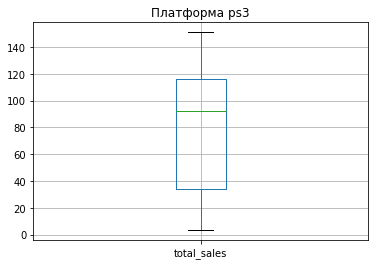

In [94]:
plot1[plot1['platform'] == 'ps3'].boxplot(column= 'total_sales');     
plt.title('Платформа ps3');

Медианное значение ~110, межквартильный размах ~80. Диапазон значений ~0..160. Выбросов нет

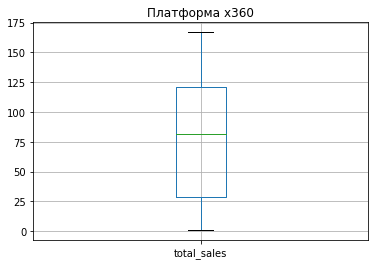

In [95]:
plot1[plot1['platform'] == 'x360'].boxplot(column= 'total_sales');   
plt.title('Платформа x360');

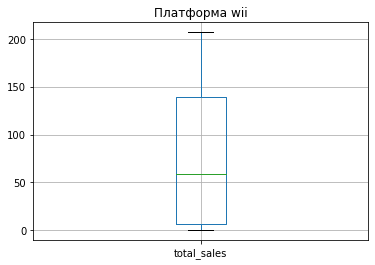

In [96]:
plot1[plot1['platform'] == 'wii'].boxplot(column= 'total_sales');   
plt.title('Платформа wii');

Медианное значение ~60, межквартильный размах ~140. Диапазон значений 0..210. Выбросов нет

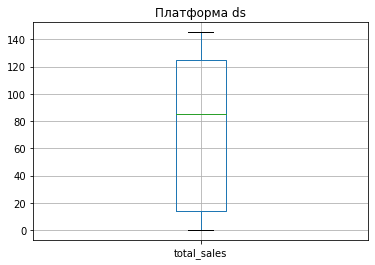

In [97]:
plot1[plot1['platform'] == 'ds'].boxplot(column= 'total_sales');   
plt.title('Платформа ds');

Медианное значение ~85, межквартильный размах ~100. Диапазон значений 15..125. Выбросов нет

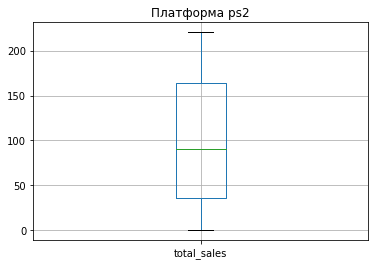

In [98]:
plot1[plot1['platform'] == 'ps2'].boxplot(column= 'total_sales');   
plt.title('Платформа ps2');

Медианное значение ~95, межквартильный размах ~120. Диапазон значений 0..225. Выбросов нет

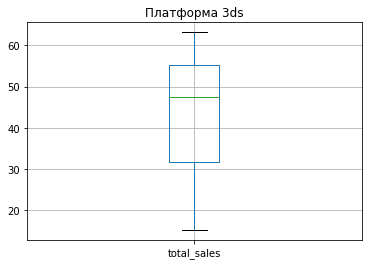

In [99]:
plot1[plot1['platform'] == '3ds'].boxplot(column= 'total_sales');   
plt.title('Платформа 3ds');

Медианное значение ~45, межквартильный размах ~40. Диапазон значений 10...65 Выбросов нет

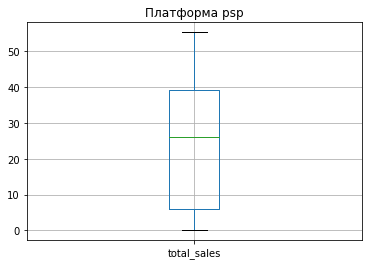

In [100]:
plot1[plot1['platform'] == 'psp'].boxplot(column= 'total_sales');   
plt.title('Платформа psp');

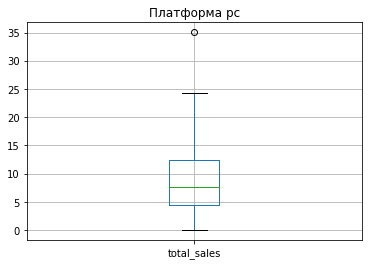

In [101]:
plot1[plot1['platform'] == 'pc'].boxplot(column= 'total_sales');  
plt.title('Платформа pc');

Медианное значение ~8, межквартильный размах ~8. Диапазон значений 0...25. Есть выбросы - 21, 35

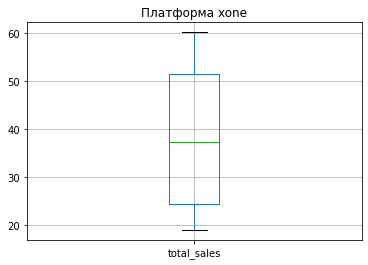

In [102]:
plot1[plot1['platform'] == 'xone'].boxplot(column= 'total_sales');
plt.title('Платформа xone');

Медианное значение ~40, межквартильный размах ~30. Диапазон значений 18...60. Выбросов нет

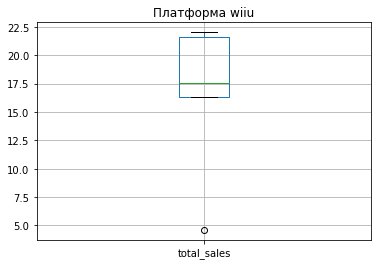

In [103]:
plot1[plot1['platform'] == 'wiiu'].boxplot(column= 'total_sales'); 
plt.title('Платформа wiiu');

Медианное значение ~17.5, межквартильный размах ~5. Диапазон значений 17...22. Есть выбросы 3 и 17

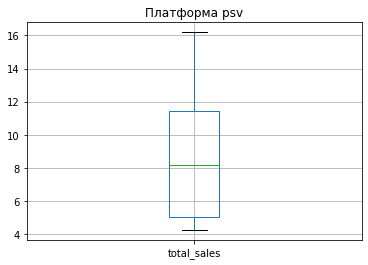

In [104]:
plot1[plot1['platform'] == 'psv'].boxplot(column= 'total_sales'); 
plt.title('Платформа psv');

Медианное значение ~9, межквартильный размах ~8.5. Диапазон значений 4...16. Выброс 13

Уберем обнаруженные выбросы

In [105]:
df_actual = df_actual[~((df_actual['platform'] == 'pc') & (df_actual['total_sales'] >20))] 
df_actual = df_actual[~((df_actual['platform'] == 'wiiu') & (df_actual['total_sales'] <5) & (df_actual['total_sales'] >17))]
df_actual = df_actual[~((df_actual['platform'] == 'psv') & (df_actual['total_sales'] <12))]

In [106]:
plot1 = (df_actual
         .pivot_table(index=['year_of_release', 'platform'], values= 'total_sales', aggfunc= 'sum')
         .reset_index(drop = False))

In [107]:
plot1 = calculate_life_cycle(plot1)

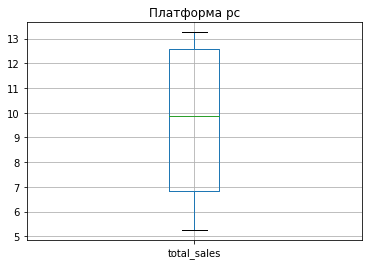

In [108]:
plot1[plot1['platform'] == 'pc'].boxplot(column= 'total_sales');  
plt.title('Платформа pc');

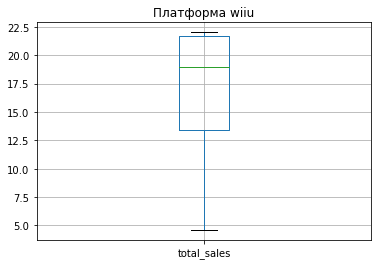

In [109]:
plot1[plot1['platform'] == 'wiiu'].boxplot(column= 'total_sales');  
plt.title('Платформа wiiu');

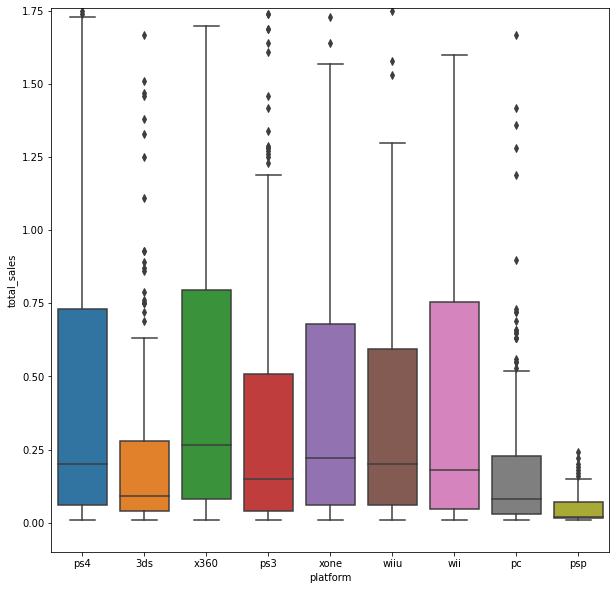

In [160]:
fig, ax = plt.subplots(figsize= [10,10])
sns.boxplot(data= df_actual, x="platform", y="total_sales");
plt.ylim(-0.1, 1.76);

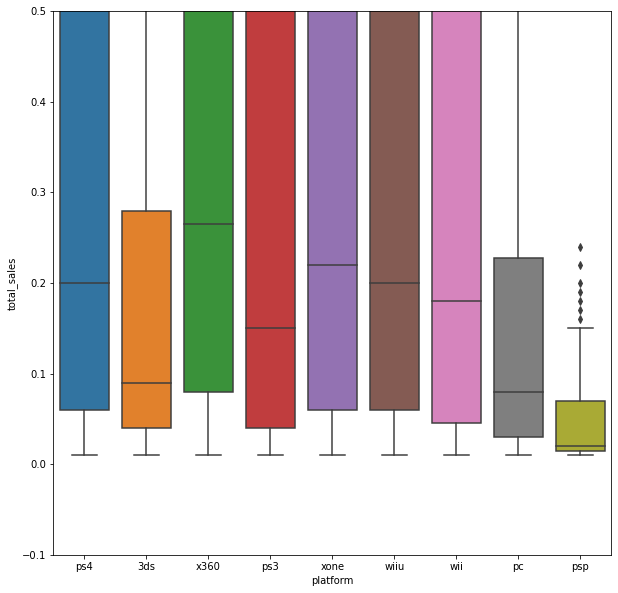

In [158]:
fig, ax = plt.subplots(figsize= [10,10])
sns.boxplot(data= df_actual, x="platform", y="total_sales");
plt.ylim(-0.1, 0.5);

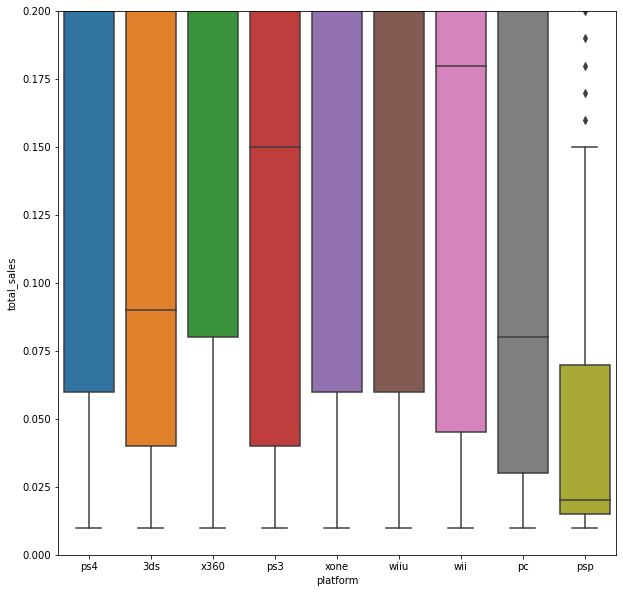

In [161]:
fig, ax = plt.subplots(figsize= [10,10])
sns.boxplot(data= df_actual, x="platform", y="total_sales");
plt.ylim(0, 0.2);

Для PS4 медианное значение ~0.2, межквартильный размах ~0.7. Диапазон значений 0...1.75. Есть выброс > 1.75
Для 3ds медианное значение ~0.1, межквартильный размах ~0.28. Диапазон значений 0...0.7. Есть выбросы > 0.7
Для x360 медианное значение ~0.1, межквартильный размах ~0.28. Диапазон значений 0...0.7. Выбросов нет 
Для ps3 медианное значение ~0.15, межквартильный размах ~0.45. Диапазон значений 0...1.2. Есть выбросы > 1.2
Для xone медианное значение ~0.23, межквартильный размах ~0.6. Диапазон значений 0...1.2. Есть выбросы > 1.2
Для wiiu медианное значение ~0.2, межквартильный размах ~0.65. Диапазон значений 0...1.3. Есть выбросы > 1.3
Для wii  медианное значение ~0.175, межквартильный размах ~0.7. Диапазон значений 0...1.6. Выбросов нет 
Для pc  медианное значение ~0.08, межквартильный размах ~0.2. Диапазон значений 0...0.5. Есть выбросы > 0.5
Для psp  медианное значение ~0.024, межквартильный размах ~0.07. Диапазон значений 0...0.150. Есть выбросы > 0.15

У всех графиков есть значения в 4-ом квартиле, которые существенно превышают медиану. Скорее всего это связано с тем, что каждая платформа имеет свои "хиты", которых не может быть много. Интересно что по среднему значению лидирует x360 и xone, а ps4 выбивается в лидеры по суммарным продажам из-за хитов.

## 4. 6. Влияние отзывов пользователей и критиков на продажи в одной популярной платформе и других платформах

Для анализа выберем ps4

In [111]:
df_ps4 = df_actual[df_actual['platform'] == 'ps4']
df_ps4.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,387.000000,387.000000,387.000000,387.000000,387.000000,247.000000,252.000000,387.000000
mean,2015.152455,0.270233,0.347726,0.040258,0.119638,72.542510,6.819841,0.777855
std,0.863787,0.556241,0.757049,0.067240,0.238360,11.656553,1.332195,1.502207
min,2013.000000,0.000000,0.000000,0.000000,0.000000,19.000000,2.300000,0.010000
25%,2015.000000,0.005000,0.000000,0.000000,0.010000,67.000000,6.200000,0.060000
50%,2015.000000,0.060000,0.080000,0.020000,0.030000,74.000000,7.100000,0.200000
75%,2016.000000,0.260000,0.300000,0.050000,0.110000,80.000000,7.800000,0.730000
max,2016.000000,6.030000,6.120000,0.490000,2.380000,93.000000,9.200000,14.630000


In [112]:
df_ps4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd,total_sales
29,call_of_duty:_black_ops_3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,False,14.63
68,fifa_16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,False,8.58
78,star_wars_battlefront_(2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,False,7.98
83,call_of_duty:_advanced_warfare,ps4,2014,shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,False,7.66
85,fifa_17,ps4,2016,sports,0.66,5.75,0.08,1.11,85.0,5.0,E,False,7.60


Пострим диаграммы рассеяния

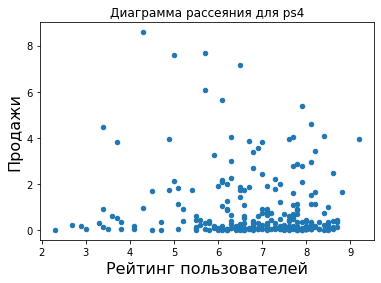

In [113]:
df_ps4.plot(x= 'user_score', y='total_sales', kind= 'scatter'); 
plt.title('Диаграмма рассеяния для ps4')
plt.xlabel('Рейтинг пользователей', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 

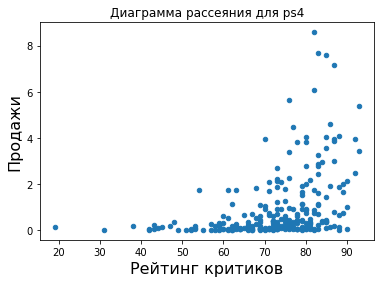

In [114]:
df_ps4.plot(x= 'critic_score', y='total_sales', kind= 'scatter'); 
plt.title('Диаграмма рассеяния для ps4')
plt.xlabel('Рейтинг критиков', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 

Построим матрицу корреляции

In [115]:
corr = df_ps4[['critic_score', 'user_score', 'total_sales']].corr().round(3)
corr.style.background_gradient(cmap='coolwarm')

,critic_score,user_score,total_sales
critic_score,1.000000,0.480000,0.399000
user_score,0.480000,1.000000,-0.109000
total_sales,0.399000,-0.109000,1.000000


**Вывод:** Оценки пользователей имеют слабую отрицательную корреляцию с продажами игр на ps4 (для пользователей -0.1).Оценки пользователей слобо связаны с продажами. Оценки критиков имеют умеренную положительную корреляцию ~ 0,4. Оценки критиков оказывают умеренное влияние.

Посмотрим работает ли данная закономерность на других платформах

Для xone и 3ds

In [116]:
df_xone = df_actual[df_actual['platform'] == 'xone']
df_xone.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,245.00000,245.00000,245.000000,245.000000,245.000000,168.000000,180.000000,245.000000
mean,2014.95102,0.36849,0.201633,0.001388,0.056327,73.184524,6.541111,0.627837
std,0.95259,0.61328,0.343839,0.005173,0.090764,12.861603,1.334911,0.992535
min,2013.00000,0.00000,0.000000,0.000000,0.000000,20.000000,2.100000,0.010000
25%,2014.00000,0.03000,0.020000,0.000000,0.010000,66.000000,5.800000,0.060000
50%,2015.00000,0.12000,0.070000,0.000000,0.020000,76.000000,6.800000,0.220000
75%,2016.00000,0.38000,0.220000,0.000000,0.060000,82.000000,7.500000,0.680000
max,2016.00000,4.59000,2.120000,0.040000,0.680000,95.000000,9.200000,7.390000


In [117]:
df_3ds = df_actual[df_actual['platform'] == '3ds']
df_3ds.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,303.000000,303.000000,303.000000,303.000000,303.000000,71.000000,80.000000,303.000000
mean,2014.287129,0.126073,0.102178,0.223795,0.020726,68.338028,6.976250,0.472772
std,1.054821,0.499331,0.381832,0.566661,0.078509,13.093012,1.538884,1.381347
min,2013.000000,0.000000,0.000000,0.000000,0.000000,26.000000,2.400000,0.010000
25%,2013.000000,0.000000,0.000000,0.010000,0.000000,61.000000,6.300000,0.040000
50%,2014.000000,0.000000,0.000000,0.060000,0.000000,69.000000,7.300000,0.090000
75%,2015.000000,0.050000,0.040000,0.145000,0.010000,78.500000,8.200000,0.280000
max,2016.000000,5.280000,4.190000,4.350000,0.780000,91.000000,9.000000,14.600000


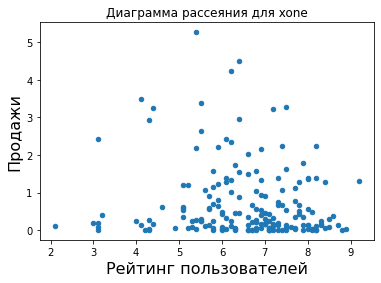

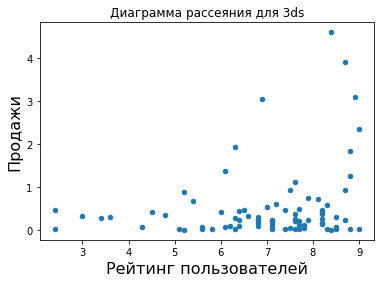

In [118]:
df_xone.plot(x= 'user_score', y='total_sales', kind= 'scatter'); 
plt.title('Диаграмма рассеяния для xone')
plt.xlabel('Рейтинг пользователей', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 

df_3ds.plot(x= 'user_score', y='total_sales', kind= 'scatter'); 
plt.title('Диаграмма рассеяния для 3ds')
plt.xlabel('Рейтинг пользователей', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 

plt.show();

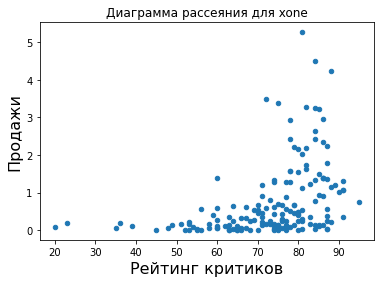

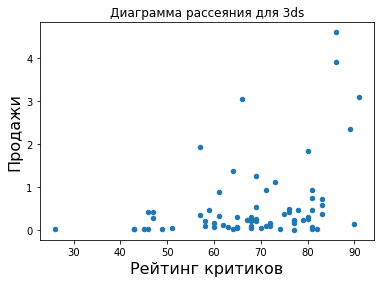

In [119]:
df_xone.plot(x= 'critic_score', y='total_sales', kind= 'scatter'); 
plt.title('Диаграмма рассеяния для xone')
plt.xlabel('Рейтинг критиков', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 

df_3ds.plot(x= 'critic_score', y='total_sales', kind= 'scatter'); 
plt.title('Диаграмма рассеяния для 3ds')
plt.xlabel('Рейтинг критиков', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 

plt.show();

Кореляции для xone

In [120]:
corr = df_xone[['critic_score', 'user_score', 'total_sales']].corr().round(3)
corr.style.background_gradient(cmap='coolwarm')

,critic_score,user_score,total_sales
critic_score,1.000000,0.467000,0.396000
user_score,0.467000,1.000000,-0.120000
total_sales,0.396000,-0.120000,1.000000


**Вывод:**  Для xone похожая картина

Кореляции для 3ds

In [121]:
corr = df_3ds[['critic_score', 'user_score', 'total_sales']].corr().round(3)
corr.style.background_gradient(cmap='coolwarm')

,critic_score,user_score,total_sales
critic_score,1.000000,0.770000,0.357000
user_score,0.770000,1.000000,0.242000
total_sales,0.357000,0.242000,1.000000


Для остальных платформ аналогичная картина

**Вывод:** Для 3ds оценки пользователей имеют корреляцию сильнее и с другим знаком, однако все равно она относительно слабая

## 4. 7. Общее распределение игр по жанрам

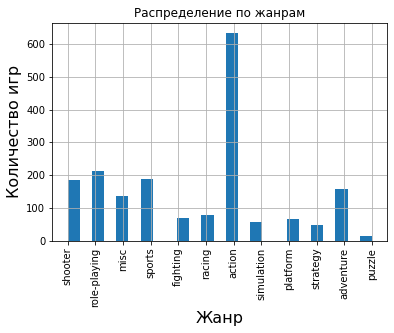

In [122]:
df_actual.genre.hist(bins= 25);
plt.xticks(rotation=90);
plt.title('Распределение по жанрам');
plt.xlabel('Жанр', fontsize = 16);
plt.ylabel('Количество игр', fontsize = 16); 

In [123]:
df_actual.genre.value_counts()

action          633
role-playing    213
sports          188
shooter         185
adventure       158
misc            135
racing           79
fighting         70
platform         66
simulation       58
strategy         48
puzzle           15
Name: genre, dtype: int64

Больше всего игр выпускаются в жанре **action**, **role-playing** и **adventure**. Меньше всего в **strategy**, **puzle**, **simulation** 

Построим график суммарных продаж по жанрам

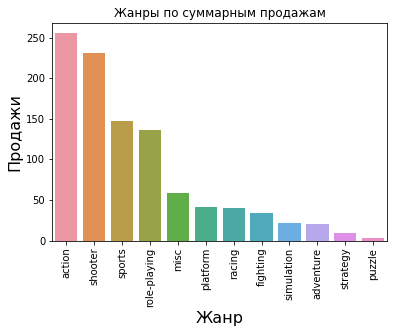

In [124]:
(sns.barplot(data= df_actual.pivot_table(index= 'genre', values= 'total_sales', aggfunc = 'sum')
             .reset_index(drop = False).sort_values(by = 'total_sales', ascending = False),              
             x= 'genre', y='total_sales'));
plt.title('Жанры по суммарным продажам')
plt.xlabel('Жанр', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 
plt.xticks(rotation=90)
plt.show()

Найдем самые прибыльные жанры (медианные продажи игры каждого жанра)

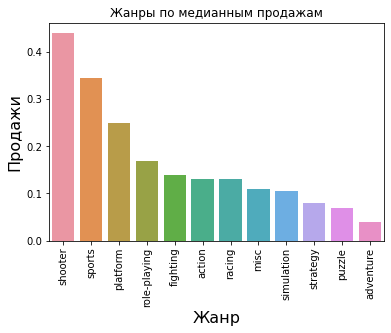

In [125]:
(sns.barplot(data= df_actual.pivot_table(index= 'genre', values= 'total_sales', aggfunc = 'median')
             .reset_index(drop = False).sort_values(by = 'total_sales', ascending = False),              
             x= 'genre', y='total_sales'));
plt.title('Жанры по медианным продажам')
plt.xlabel('Жанр', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 
plt.xticks(rotation=90)
plt.show()

**Вывод:** Наиболее прибыльные жанры(по медианному значению продаж игр): **shooter**, **sports**, **platform**. Наименее прибыльные жанры(по медианному значению продаж игр): **strategy**, **puzzle**, **adventure**

**Вывод по исследовательскому анализу данных:**

В ходе исследовательского анализа данных было выполнено:  

1. Изучено и визуализированно количество игр по годам выпуска
2. Изучена и визуализирована динамика продаж по платформам за разные годы. Вычислен'срок жизни' платформы
3. На основе этих данных был выбран актуальный период для прогноза на 2017 год
4. Были изучены и визуализированны лидирующие и отстающие платформы по суммарным продажам 
5. Для платформы ps3 были построены диаграммы рассеяния по оценкам пользователей и критиков. Определена корреляция   
"Продажи-оценки пользователей", "Продажи-оценки критиков"
6. Построены диаграммы размаха для каждой платформы
7. Изучено и визуализированно общее распределение по жанрам. Были определены самые прибыльные жанры

В ходе данного этапа получили следующие выводы:

1. Количество игр, выпущенное до **2000** года и находящееся в продаже крайне мало
2. Медианный жизненный цикл платформы - **8** лет. Динамика продаж по платформам индивидуальна для каждой платформы
3. На основе этих данных был выбран актуальный период в **4** года, так как он укладывается в половину медианного срока жизни платформы, а нас интересуют платформы на пике популярности
4. Самые "продаваемые" платформы **ps4, xone, 3ds** , наименее продаваемые - wii, psp. Наиболее перспективные ps4 и xone
5. Оценки критиков оказывают умеренное влияние на продажи на всех платформах. Оценки пользователей слабо влияют на продажи. 
6. По построенным диаграммам размаха были удалены 2 выброс
7. Больше всего игр выпускаются в жанре **action**, **shooter** и **sports**. Меньше всего в **simulation**, **strategy**, **puzle**, **platform** 
Наиболее прибыльные жанры - **shooter**, **sports**, **platform**. Наименее прибыльные - **puzzle**, **strategy**, **adventure**

# 5.  Портрет пользователя каждого региона

## 5.1. Самые популярные платформы (топ-5).

### 5.1.1. Топ 5. Самые популярные платформы по Северной Америке (na)

In [126]:
df_actual_na = (
    df_actual.
    pivot_table(index= 'platform', values= 'na_sales', aggfunc = 'sum')
    .sort_values(by='na_sales', ascending = False)
    .reset_index(drop= False)
    .loc[0:4]
)
df_actual_na

,platform,na_sales
0,ps4,104.58
1,xone,90.28
2,x360,71.75
3,ps3,56.12
4,3ds,38.20


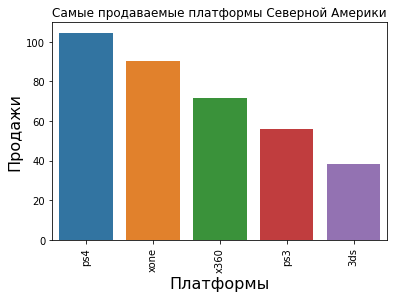

In [127]:
(sns.barplot(data= df_actual_na, x= 'platform', y='na_sales'));  
plt.title('Самые продаваемые платформы Северной Америки')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 
plt.xticks(rotation=90)
plt.show()

### 5.1.2. Топ 5. Самые популярные платформы по Европе (eu)

In [128]:
df_actual_eu = (
    df_actual.
    pivot_table(index= 'platform', values= 'eu_sales', aggfunc = 'sum')
    .sort_values(by='eu_sales', ascending = False)
    .reset_index(drop= False)
    .loc[0:4]
)
df_actual_eu

,platform,eu_sales
0,ps4,134.57
1,ps3,58.56
2,xone,49.40
3,x360,37.07
4,3ds,30.96


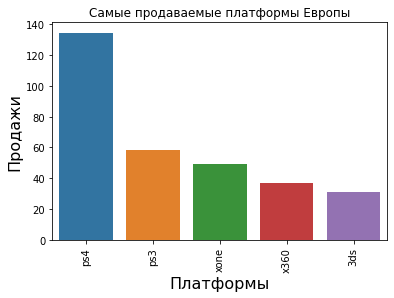

In [129]:
(sns.barplot(data= df_actual_eu, x= 'platform', y='eu_sales'));  
plt.title('Самые продаваемые платформы Европы')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 
plt.xticks(rotation=90)
plt.show()

### 5.1.3. Топ 5. Самые популярные платформы по Японии (jp)

In [130]:
df_actual_jp = (
    df_actual.
    pivot_table(index= 'platform', values= 'jp_sales', aggfunc = 'sum')
    .sort_values(by='jp_sales', ascending = False)
    .reset_index(drop= False)
    .loc[0:4]
)
df_actual_jp

,platform,jp_sales
0,3ds,67.81
1,ps3,22.37
2,ps4,15.58
3,wiiu,10.88
4,psp,3.29


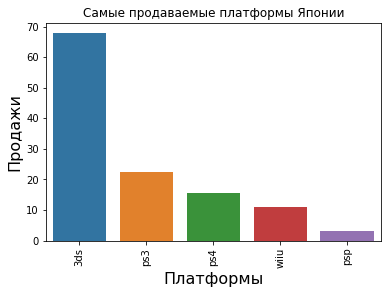

In [131]:
(sns.barplot(data= df_actual_jp, x= 'platform', y='jp_sales'));  
plt.title('Самые продаваемые платформы Японии')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Продажи', fontsize = 16); 
plt.xticks(rotation=90)
plt.show()

### 5.1.4. Различия по долям продаж 

In [132]:
def get_pie_data(df:pd.DataFrame, region_sales:str) -> list:
    pie_data = []
    pie_legend = []
    for platform in df.platform.unique():
             pie_legend.append(platform)
             pie_data.append(df[df['platform'] == platform][region_sales].sum())  
    return pie_data, pie_legend

In [133]:
pie_data_na, pie_legend_na = get_pie_data(df_actual_na, 'na_sales')
pie_data_eu, pie_legend_eu = get_pie_data(df_actual_eu, 'eu_sales')
pie_data_jp, pie_legend_jp = get_pie_data(df_actual_jp, 'jp_sales')

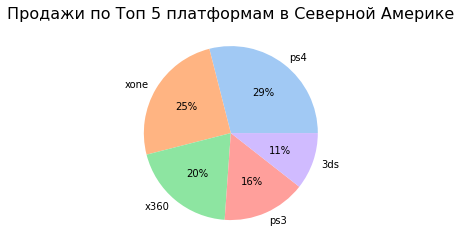

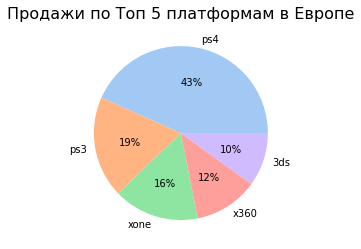

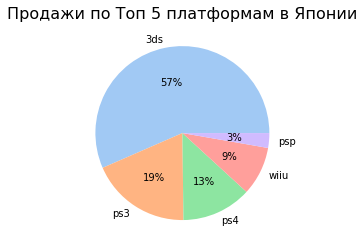

In [134]:
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(pie_data_na, labels = pie_legend_na, colors = colors, autopct='%.0f%%')
plt.title('Продажи по Топ 5 платформам в Северной Америке', fontsize = 16);
plt.show()

plt.pie(pie_data_eu, labels = pie_legend_eu, colors = colors, autopct='%.0f%%')
plt.title('Продажи по Топ 5 платформам в Европе', fontsize = 16);
plt.show()

plt.pie(pie_data_jp, labels = pie_legend_jp, colors = colors, autopct='%.0f%%')
plt.title('Продажи по Топ 5 платформам в Японии', fontsize = 16);
plt.show()

**Вывод**: В северной америке лидируют ps4, xone, x360 (29%, 25%, 20% от продаж по топ 5 соответственно). В Европе данные  ps4, ps4, ps3, xone (43%, 19%, 16% от продаж по топ 5 соответственно). Для Японии совершенно другая картина: 3ds,ps3, psv (50%, 17%, 17% соответствено)

## 5.1. Самые популярные жанры (топ-5).

In [135]:
def get_pie_genre(df:pd.DataFrame, region_sales:str) -> list:
    pie_data = []
    pie_legend = []
    for genre in df.genre.unique():
             pie_legend.append(genre)
             pie_data.append(df[df['genre'] == genre][region_sales].sum())  
    return pie_data, pie_legend

In [136]:
df_actual_na = (
    df_actual.
    pivot_table(index= 'genre', values= 'na_sales', aggfunc = 'sum')
    .sort_values(by='na_sales', ascending = False)
    .reset_index(drop= False)
    .loc[0:4]
)

df_actual_eu = (
    df_actual.
    pivot_table(index= 'genre', values= 'eu_sales', aggfunc = 'sum')
    .sort_values(by='eu_sales', ascending = False)
    .reset_index(drop= False)
    .loc[0:4]
)

df_actual_jp = (
    df_actual.
    pivot_table(index= 'genre', values= 'jp_sales', aggfunc = 'sum')
    .sort_values(by='jp_sales', ascending = False)
    .reset_index(drop= False)
    .loc[0:4]
)

In [137]:
pie_data_na, pie_legend_na = get_pie_genre(df_actual_na, 'na_sales')
pie_data_eu, pie_legend_eu = get_pie_genre(df_actual_eu, 'eu_sales')
pie_data_jp, pie_legend_jp = get_pie_genre(df_actual_jp, 'jp_sales')

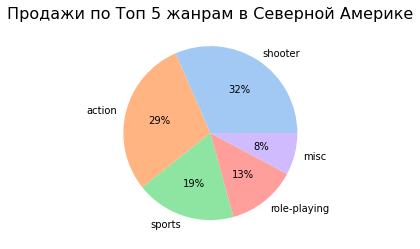

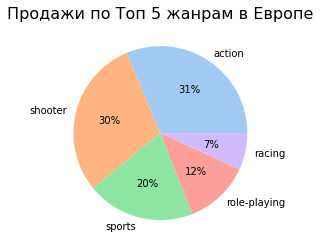

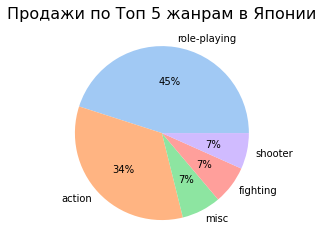

In [138]:
colors = sns.color_palette('pastel')[ 0:10 ]

plt.pie(pie_data_na, labels = pie_legend_na, colors = colors, autopct='%.0f%%')
plt.title('Продажи по Топ 5 жанрам в Северной Америке', fontsize = 16);
plt.show()

plt.pie(pie_data_eu, labels = pie_legend_eu, colors = colors, autopct='%.0f%%')
plt.title('Продажи по Топ 5 жанрам в Европе', fontsize = 16);
plt.show()

plt.pie(pie_data_jp, labels = pie_legend_jp, colors = colors, autopct='%.0f%%')
plt.title('Продажи по Топ 5 жанрам в Японии', fontsize = 16);
plt.show()

**Вывод**: В северной америке лидируют action, shooter, sports (29%, 23%, 21% от продаж по топ 5 соответственно). В Европе так же данные лидируют те же жанры (31%, 24%, 22% от продаж по топ 5 соответственно). Для Японии совершенно другая картина: role-playing, action, misc (42%, 26%, 14% соответствено)

Такая разница может быть объяснена тем, что в Японии популярны другие платформы (3ds)

## 5.3. Влияние ли рейтинга ESRB на продажи в отдельном регионе

### 5.3.1. Для Северной Америки 

In [139]:
df_actual_na = (
    df_actual.
    pivot_table(index= 'rating', values= 'na_sales', aggfunc = 'sum')
    .sort_values(by='na_sales', ascending = False)
    .reset_index(drop= False)    
)
df_actual_na

,rating,na_sales
0,M,139.87
1,E,77.94
2,E10+,53.41
3,T,48.30


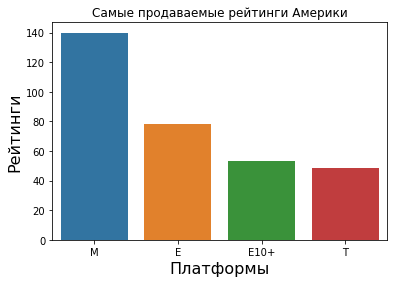

In [140]:
(sns.barplot(data= df_actual_na, x= 'rating', y='na_sales'));  
plt.title('Самые продаваемые рейтинги Америки')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Рейтинги', fontsize = 16); 
plt.show()

### 5.3.3. Для Европы

In [141]:
df_actual_eu = (
    df_actual.
    pivot_table(index= 'rating', values= 'eu_sales', aggfunc = 'sum')
    .sort_values(by='eu_sales', ascending = False)
    .reset_index(drop= False)    
)
df_actual_eu

,rating,eu_sales
0,M,120.72
1,E,81.47
2,E10+,41.19
3,T,40.65


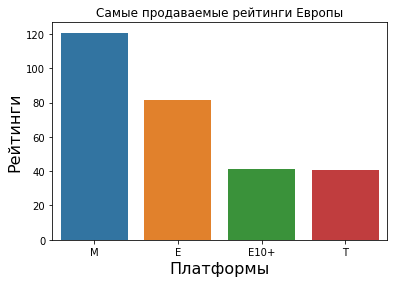

In [142]:
(sns.barplot(data= df_actual_eu, x= 'rating', y='eu_sales'));  
plt.title('Самые продаваемые рейтинги Европы')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Рейтинги', fontsize = 16); 
plt.show()

### 5.3.3. Для Японии

In [143]:
df_actual_jp = (
    df_actual.
    pivot_table(index= 'rating', values= 'jp_sales', aggfunc = 'sum')
    .sort_values(by='jp_sales', ascending = False)
    .reset_index(drop= False)    
)
df_actual_jp

,rating,jp_sales
0,T,15.51
1,E,15.08
2,M,11.27
3,E10+,5.61


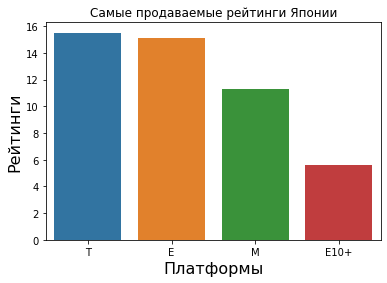

In [144]:
(sns.barplot(data= df_actual_jp, x= 'rating', y='jp_sales'));  
plt.title('Самые продаваемые рейтинги Японии')
plt.xlabel('Платформы', fontsize = 16);
plt.ylabel('Рейтинги', fontsize = 16); 
plt.show()

**Вывод**: Рейтинг оказывает существенное влияние на продажи. Для Европы/Северной Америки и Японии есть существенная разница продажах по рейтингу. Скорее все го это объясняется разными культурами и законодательством

**Вывод по портрету пользователя каждого региона:**

В ходе исследовательского анализа данных было выполнено:  

1. Изучены и визуализарованы топ-5 самых популярных платформ по регионам
2. Изучены и визуализарованы топ-5 самых популярных жанров по регионам
3. Изучено влияние рейтинга на продажи в каждом регионе

Портрет пользователя из Свеврной Америки:

    Предпочитает игры жанра action, shooter, sports на платформах ps4, xone, x360 с рейтингами E,M,T

Портрет пользователя из Европы: 

    Предпочитает игры жанра action, shooter, sports на платформах ps4, ps3, xone с рейтингами E,M,T

Портрет пользователя из Японии:

    Предпочитает игры жанра role-playing, action, misc на платформах 3ds, ps3, psv с рейтингами E,T, M

Рейтинг игры оказывает существенное влияние на продажи во всех регионах.  Для Европы/Северной Америки и Японии есть существенная разница продажах по рейтингу. Скорее все го это объясняется разными культурами и законодательством

# 6. Проверка гипотез

## 6.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Формулируем гипотезу:

Нулевая гипотеза H0:

Медианное значение пользовательского рейтинга генеральных совокупностей для платформ Xbox One и PC одинаковые 

Альтернативная гипотеза (двусторонняя) H1:

Медианное значение пользовательского рейтинга генеральных совокупностей для платформ Xbox One и PC разные

Проверка гипотезы:

In [145]:
df_actual[df_actual['platform'] == 'pc'].user_score.dropna().count()

152

In [146]:
df_actual[df_actual['platform'] == 'xone'].user_score.dropna().count()

180

In [147]:
alpha = 0.05 

df_user_score_xone = df_actual[df_actual['platform'] == 'xone'].user_score.dropna().to_list()
df_user_score_pc = df_actual[df_actual['platform'] == 'pc'].user_score.dropna().to_list()

results = st.ttest_ind(df_user_score_xone, df_user_score_pc, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.1940549761136323
Не получилось отвергнуть нулевую гипотезу


**Вывод**: Гипотезу отвергнуть не получилось. Они равны

## 6.2 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Формулируем гипотезу:

Нулевая гипотеза H0:

Медианное значение пользовательского рейтинга генеральных совокупностей для жанров Action и Sports одинаковые 

Альтернативная гипотеза (двусторонняя) H1:

Медианное значение пользовательского рейтинга генеральных совокупностей для жанров Action и Sports разные

In [148]:
df_actual[df_actual['genre'] == 'action'].user_score.dropna().count()

351

In [149]:
df_actual[df_actual['genre'] == 'sports'].user_score.dropna().count()

147

In [150]:
alpha = 0.05 

df_user_score_action= df_actual[df_actual['genre'] == 'action'].user_score.dropna().to_list()
df_user_score_sports = df_actual[df_actual['genre'] == 'sports'].user_score.dropna().to_list()

results = st.ttest_ind(df_user_score_action, df_user_score_sports, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 5.264306330043175e-18
Отвергаем нулевую гипотезу


Вывод: Нулевую гипотезу отвергаем. Альтернативную подтверждаем средние пользовательские рейтинги жанров Action и Sports   разные.

**Вывод по проверке гипотез:**


В ходе проверки гипотез:  

1. Были сформулированы нулевые и альтернативные гипотезы по 2-ум утверждениям 
2. Была проведена проверка гипотез с помощью t-теста для не равных по размеру выборок с уровнем значимости 0.05

Так как утверждения требуют проверки на равенство в обе стороны средних (в первом случаеравно, во втором не равно), нулевая гипотеза была выдвинута о равенстве средних, а альтернативная об их неравнестве.

Так как задача проверки данных гипотез -это задача о проверке гипотезы о равенстве средних двух генеральных совокупностей, был
использован T-тест. Так как совокупности не равны по размеру, был использован тест для разных по размеру совокупностей.

Стандартный уровень статистической значимости 0.05 или 0.01. Были проверены оба этих уровня. Результат не изменился

Выводы по утверждениям:

1. Средние пользовательские оценки платформ Xbox One и PC одинаковые
> **Данное утверждение подтверждаем**

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
> **Данное утверждение подтверждаем**

# 7. Общий вывод

#### 7.1. Цель работы: 

Выявить определяющие успешность игры закономерности по статистическим данным до 2016 года из открытых иточников

Результат быдет использован магазином "Стримчик", который продаёт по всему миру компьютерные игры.

#### 7.2. Описание проекта: 

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


##### 7.2. Анализ и предобработка данных представленного датасета

В ходе предобработки данных было выявлено следующее:  

1. Наименования столбцов и значений не соответствует snake_case
2. В столбцах name, genre, platform, year_of_release, critic_score, user_score, rating есть пропуски
3. Неправильные типы данных в столбцах year_of_release, user_score
4. Наличие значений 'tbd' в столбце user_score
5. Явные и не явные дубликаты отсуствуют
6. Присутствует один неполный дубликат (игра madden_nfl_13)

В ходе данного этапа:

1. Наименования столбцов были приведены к snake_case   
2. 2 строки со значениями NAN в столбцах name, genre были отброшены. 
3. Там где в имени игры присутствует год и пропущены значения year_of_release, значения в столбце year_of_release были заполнены из имени игры. Остальные значения отброшены
4. Значения 'tbd' в столбце user_score были заполнены NAN, так как tbd = to be done по смыслу и есть NAN. На всякий случай значения 'tbd' были вынесены в отдельный столбец is_tbd
5. Изменены типы в столбцах user_score и year_of_release
6. Обработаны выбросы
7. Добавлен столбец 'total_sales', с суммами продаж по всем регионам
8. Удален неполный дубликат

Данные ошибки могли появиться врезультате человеческого фактора, работы/конвертации стороннего ПО

##### 7.3. Исследовательский анализ данных

В ходе исследовательского анализа данных было выполнено:  

1. Изучено и визуализированно количество игр по годам выпуска
2. Изучена и визуализирована динамика продаж по платформам за разные годы. Вычислен'срок жизни' платформы
3. На основе этих данных был выбран актуальный период для прогноза на 2017 год
4. Были изучены и визуализированны лидирующие и отстающие платформы по суммарным продажам 
5. Для платформы ps3 были построены диаграммы рассеяния по оценкам пользователей и критиков. Определена корреляция   
"Продажи-оценки пользователей", "Продажи-оценки критиков"
6. Построены диаграммы размаха для каждой платформы
7. Изучено и визуализированно общее распределение по жанрам. Были определены самые прибыльные жанры

В ходе данного этапа получили следующие выводы:

1. Количество игр, выпущенное до **2000** года и находящееся в продаже крайне мало
2. Медианный жизненный цикл платформы - **8** лет. Динамика продаж по платформам индивидуальна для каждой платформы
3. На основе этих данных был выбран актуальный период в **4** года, так как он укладывается в половину медианного срока жизни платформы, а нас интересуют платформы на пике популярности
4. Самые "продаваемые" платформы **ps4, xone, 3ds** , наименее продаваемые - wii, psp. Наиболее перспективные ps4 и xone
5. Оценки критиков оказывают умеренное влияние на продажи на всех платформах. Оценки пользователей слабо влияют на продажи. 
6. По построенным диаграммам размаха были удалены 2 выброс
7. Больше всего игр выпускаются в жанре **action**, **shooter** и **sports**. Меньше всего в **simulation**, **strategy**, **puzle**, **platform** 
Наиболее прибыльные жанры - **shooter**, **sports**, **platform**. Наименее прибыльные - **puzzle**, **strategy**, **adventure**

4. Самые "продаваемые" платформы **ps4, xone, 3ds** , наименее продаваемые - wii, psp. Наиболее перспективные ps4 и xone

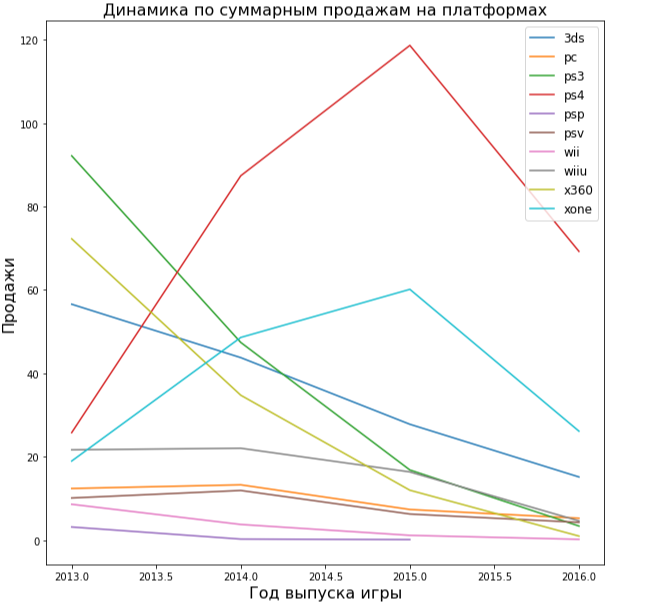 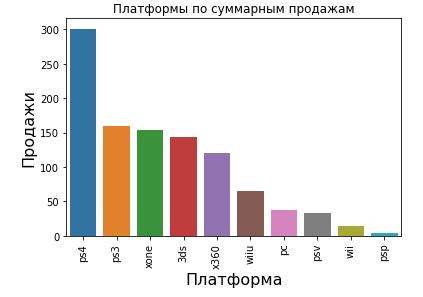

5. Корреляции не подтверждают наличие зависимости между продажами и оценками пользователей

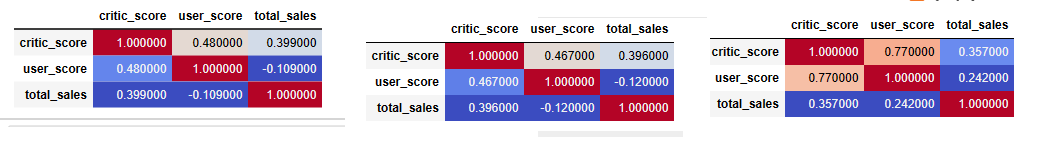

6. По построенным диаграммам размаха были удалены 2 выброс

7. Больше всего игр выпускаются в жанре **action**, **shooter** и **sports**. Меньше всего в **simulation**, **strategy**, **puzle**, **platform** 
Наиболее прибыльные жанры - **shooter**, **sports**, **platform**. Наименее прибыльные - **puzzle**, **strategy**, **adventure**

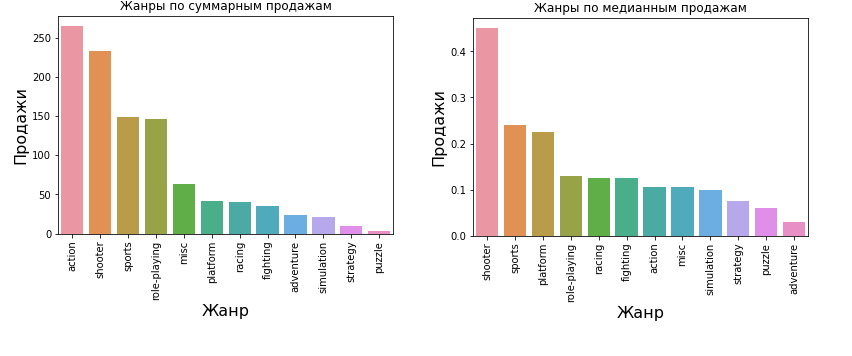

##### 7.4. Портрет пользователя каждого региона

В ходе исследовательского анализа данных было выполнено:  

1. Изучены и визуализарованы топ-5 самых популярных платформ по регионам
2. Изучены и визуализарованы топ-5 самых популярных жанров по регионам
3. Изучено влияние рейтинга на продажи в каждом регионе

Портрет пользователя из Свеврной Америки:

    Предпочитает игры жанра action, shooter, sports на платформах ps4, xone, x360 с рейтингами E,M,T

Портрет пользователя из Европы: 

    Предпочитает игры жанра action, shooter, sports на платформах ps4, ps3, xone с рейтингами E,M,T

Портрет пользователя из Японии:

    Предпочитает игры жанра role-playing, action, misc на платформах 3ds, ps3, psv с рейтингами E,T, M

Рейтинг игры оказывает существенное влияние на продажи во всех регионах.  Для Европы/Северной Америки и Японии есть существенная разница продажах по рейтингу. Скорее все го это объясняется разными культурами и законодательством

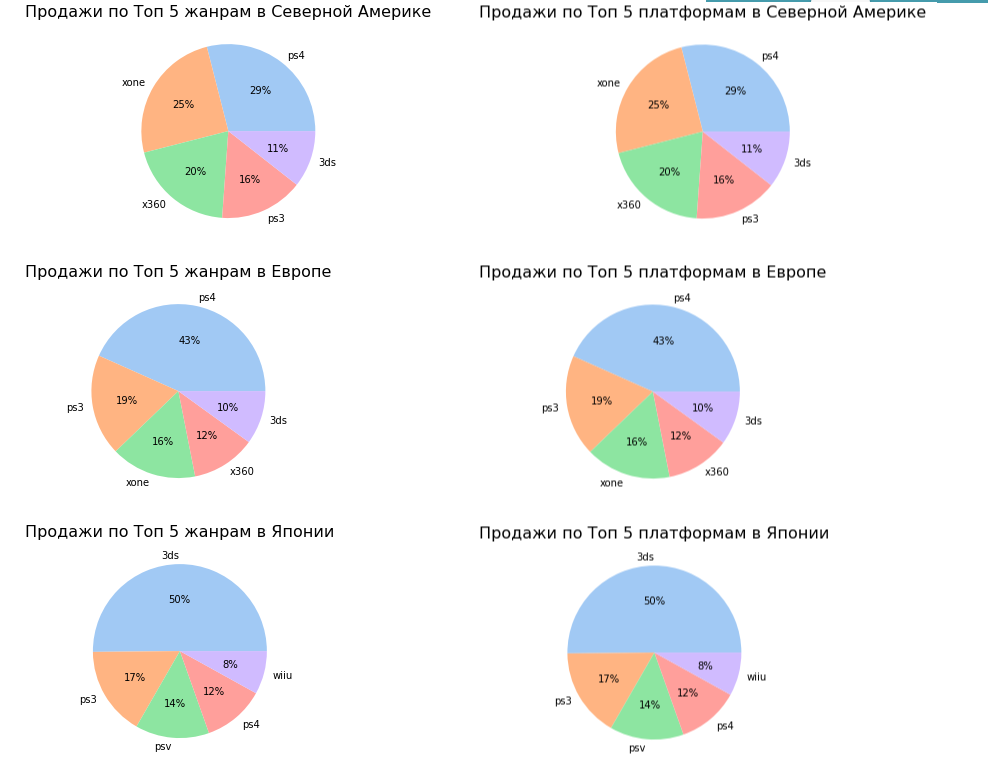

##### 7.5. Проверка гипотез

В ходе проверки гипотез:  

1. Были сформулированы нулевые и альтернативные гипотезы по 2-ум утверждениям 
2. Была проведена проверка гипотез с помощью t-теста для не равных по размеру выборок с уровнем значимости 0.05

Так как утверждения требуют проверки на равенство в обе стороны средних (в первом случаеравно, во втором не равно), нулевая гипотеза была выдвинута о равенстве средних, а альтернативная об их неравнестве.

Так как задача проверки данных гипотез -это задача о проверке гипотезы о равенстве средних двух генеральных совокупностей, был
использован T-тест. Так как совокупности не равны по размеру, был использован тест для разных по размеру совокупностей.

Стандартный уровень статистической значимости 0.05 или 0.01. Были проверены оба этих уровня. Результат не изменился

Выводы по утверждениям:

1. Средние пользовательские оценки платформ Xbox One и PC одинаковые
> **Данное утверждение подтверждаем**

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
> **Данное утверждение подтверждаем**